In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import networkx as nx
from viz import NetworkView
import matplotlib.pyplot as plt
from networks import DiscourseNetworks
import community

# Reading dna-party dataset

In [2]:
# This dataset has been created by Caroline Bhattacharya
data = pd.read_csv('../dataset/dna-party-dataset.csv', sep=",")

# Rows in dataset
data

,statement ID,time,document ID,document type,text,mp,party,concept,agreement,category
0,480,2010-05-07,2,EoV,"Mir ist bewusst, dass es inzwischen unausweich...","Aschenberg-Dugnus, Christine",FDP,Aid_Currency stabilisation,1,Policy
1,479,2010-05-07,2,EoV,Die von der Bundesregierung nun eingeleiteten ...,"Aschenberg-Dugnus, Christine",FDP,Crisis_Contagion,1,Polity
2,2,2010-05-07,2,EoV,Die von der Bundesregierung nun eingeleiteten ...,"Aschenberg-Dugnus, Christine",FDP,Alternatives,0,Politics
3,482,2010-05-07,2,EoV,"Gleichwohl ist daran zu erinnern, dass zunäch...","Aschenberg-Dugnus, Christine",FDP,EMU_Self-responsibility,1,Polity
4,481,2010-05-07,2,EoV,Die Zugehörigkeit zur Euro-Zone darf keinen A...,"Aschenberg-Dugnus, Christine",FDP,Solidarity_European,0,Polity
...,...,...,...,...,...,...,...,...,...,...
9043,4564,2015-08-19,410,EoV,Die Syriza-Regierung muss sechs der von ihr ei...,Left,Left,Aid_National sovereignty,0,Policy
9044,4567,2015-08-19,410,EoV,Eine Rückkehr zum früheren kollektiven Tarif...,Left,Left,Greece_Collective bargaining,1,Policy
9045,4574,2015-08-19,410,EoV,"Von den Maßnahmen, die die neue griechische Re...",Left,Left,Greece_Reforms_Social,1,Policy
9046,4576,2015-08-19,410,EoV,"Von den Maßnahmen, die die neue griechische Re...",Left,Left,Greece_Public sector_Job cuts,0,Policy


# Dataset summary

In [3]:
# Example summary of the dataset
data.groupby('time').count()

,statement ID,document ID,document type,text,mp,party,concept,agreement,category
time,,,,,,,,,
2010-05-07,1925,1925,1925,1925,1925,1925,1925,1925,1925
2012-02-27,1784,1784,1784,1784,1784,1784,1784,1784,1784
2015-02-27,2567,2567,2567,2567,2567,2567,2567,2567,2567
2015-07-17,1560,1560,1560,1560,1560,1560,1560,1560,1560
2015-08-19,1212,1212,1212,1212,1212,1212,1212,1212,1212


In [4]:
data.groupby('party').count()

,statement ID,time,document ID,document type,text,mp,concept,agreement,category
party,,,,,,,,,
CDU,2968,2968,2968,2968,2968,2968,2968,2968,2968
CSU,501,501,501,501,501,501,501,501,501
FDP,348,348,348,348,348,348,348,348,348
Greens,2087,2087,2087,2087,2087,2087,2087,2087,2087
Left,1146,1146,1146,1146,1146,1146,1146,1146,1146
SPD,1998,1998,1998,1998,1998,1998,1998,1998,1998


In [5]:
data.groupby('document type').count()

,statement ID,time,document ID,text,mp,party,concept,agreement,category
document type,,,,,,,,,
EoV,7037,7037,7037,7037,7037,7037,7037,7037,7037
Speech,2011,2011,2011,2011,2011,2011,2011,2011,2011


# Filtering dataset for building networks

In [8]:
def select_data(data, party=['CDU'], debate_date='2010-05-07', doc_type=None):
    
    # Selecting party specific data
    data = data[data['party'].isin(party)]
    
    # Selecting document type
    if doc_type in ['Speech', 'EoV']:
        data = data[data['document type'] == doc_type]
    
    # Selecting debate     
    data = data[data['time'] == debate_date]
    
    return data

In [9]:
party_data = select_data(data, party=['CDU', 'CSU', 'SPD', 'FDP', 'Left', 'Greens'], doc_type=None, debate_date='2015-08-19')

# Creating networks

In [10]:
dnet = DiscourseNetworks()
# Minimum threshold
min_concepts = 2
count_data, actor_id_map = dnet.build_data(party_data, 'mp', 'concept', 'agreement', add_field='party')

[*] Building statement data ...
	Number of actors = 46
	Number of concepts = 208
	Number of qualifier levels = 2


In [11]:
cong_net = dnet.get_actor_congruence_network(count_data, normalization='avg', min_concepts=min_concepts)
conf_net = dnet.get_actor_conflict_network(count_data, normalization='avg', min_concepts=min_concepts)
subs_net = cong_net - conf_net

# Plotting subtract network

In [12]:
def get_net(net_adj, id_map=None, node_scale=50, layout_type='sp'):
    
    # Generating the graph
    G = NetworkView.gen_simple_graph(net_adj)
    n = len(nx.nodes(G))
    
    if layout_type == 'sp':
        pos = nx.spring_layout(G)
    elif layout_type == 'c':
        pos = nx.circular_layout(G)
    elif layout_type == 'r':
        pos = nx.random_layout(G)
    elif layout_type == 'kk':
        pos = nx.kamada_kawai_layout(G)
    else:
        pos = nx.spiral_layout(G)

    return G, pos


def plot_subtract_net(G, G_pos, remove_isolates=False, id_map=None, node_scale=50, filename='Net/Subtract.png'):
    
    PARTY_COLOR = {'CDU': "#5F5858", 
                   'CSU': "#4CBFD3", 
                   'FDP': "#F3E72A", 
                   'Greens': "#24AD3F", 
                   'Left': "#E949BE", 
                   'SPD': "#DE4044"
                  }    
    fig = plt.figure(figsize=(10, 10))
    
    if remove_isolates:
        G.remove_nodes_from(list(nx.isolates(G)))
    
    if id_map is not None:        
        rev_map = id_map.get_reverse_map()
        actor_info = [rev_map.get(i) for i in G.nodes()]
        color = list(map(lambda x: PARTY_COLOR[x.get('party')], actor_info))
    else:
        color = "blue"
        
    # Getting graph information
    g_d = dict(G.degree)
    g_edge_data = G.edges.data()
    g_edge_width = np.array([x[-1].get('weight') for x in g_edge_data])
    edge_color = ['gray' if x >=0 else 'tomato' for x in g_edge_width]
    
    min_edge = np.min(abs(g_edge_width))
    max_edge = np.max(abs(g_edge_width))
    all_nodes = np.array(list(g_d.values()))
    min_node = np.min(all_nodes)
    max_node = np.max(all_nodes)
                            
    edge_width = 1 + 5 * (g_edge_width - min_edge) / (max_edge - min_edge)
    g_node_size = 200 + 1500 * (np.array(list(g_d.values())) - min_node) / (max_node - min_node)
    
    nx.draw(G, 
            G_pos, 
            nodelist=g_d.keys(), 
            node_size=g_node_size, 
            alpha=.8, 
            node_color=color,
            edge_color=edge_color,
            width=edge_width,
            with_labels=True) # Change True to False for removing labels
    
#     fig.savefig(filename, bbox_inches='tight', dpi=300)

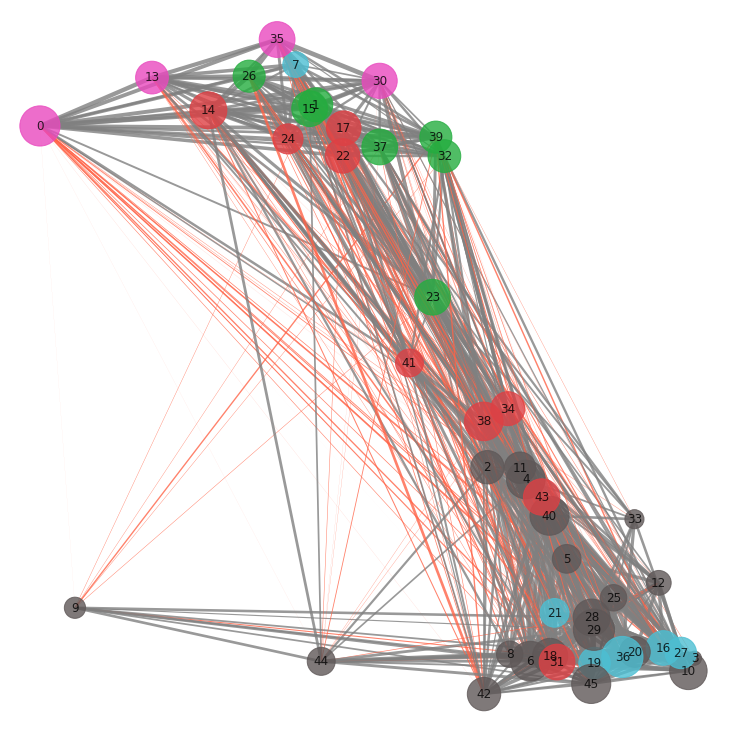

In [13]:
G, G_pos = get_net(subs_net, id_map=actor_id_map, layout_type='sp')
plot_subtract_net(G, G_pos, id_map=actor_id_map, node_scale=50, filename='Net/Subtract.png')

In [14]:
# Identifying actors
rev_map = actor_id_map.get_reverse_map()
rev_map[2]

{'name': 'Bellmann, Veronika', 'party': 'CDU'}

# Computing modularity

In [18]:
def partition_graph(net_adj, remove_node=None):
    # Generating the graph
    G = NetworkView.gen_simple_graph(net_adj)
    G.remove_nodes_from(list(nx.isolates(G)))
    
    if remove_node is not None:
        G.remove_nodes_from(remove_node)
        
    partition = community.best_partition(G)
    print('No. of partitions = ', float(len(set(partition.values()))))
    
    size = float(len(set(partition.values())))
    pos = nx.spring_layout(G)
    print('Modularity score: ', community.modularity(partition, G))
#     pos = nx.random_layout(G)
    count = 0.
    plt.figure(figsize=(5,5))
    for com in set(partition.values()) :
        count = count + 1.
        list_nodes = [nodes for nodes in partition.keys()
                                    if partition[nodes] == com]
        nx.draw_networkx_nodes(G, pos, list_nodes, node_size = 20,
                                    node_color = str(count / size))


    nx.draw_networkx_edges(G, pos, alpha=0.5)

No. of partitions =  2.0
Modularity score:  0.1872540467390352


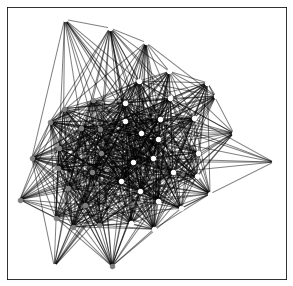

In [21]:
partition_graph(abs(subs_net), remove_node=None)